In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "flow_vcr_mse"
ood = "0"

In [3]:
# Parameters
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                             | 0/60000 [00:00<?, ?it/s]

 10%|█████████▌                                                                                     | 6052/60000 [00:00<00:00, 60509.96it/s]

 21%|███████████████████▊                                                                          | 12676/60000 [00:00<00:00, 63874.91it/s]

 32%|██████████████████████████████▍                                                               | 19419/60000 [00:00<00:00, 65496.14it/s]

 44%|████████████████████████████████████████▉                                                     | 26108/60000 [00:00<00:00, 66043.98it/s]

 55%|███████████████████████████████████████████████████▍                                          | 32871/60000 [00:00<00:00, 66613.72it/s]

 66%|██████████████████████████████████████████████████████████████                                | 39607/60000 [00:00<00:00, 66864.21it/s]

 77%|████████████████████████████████████████████████████████████████████████▌                     | 46329/60000 [00:00<00:00, 66979.13it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████           | 53027/60000 [00:00<00:00, 66905.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████▌| 59743/60000 [00:00<00:00, 66984.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 66114.95it/s]

  0%|                                                                                                             | 0/10000 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████▊                                | 6616/10000 [00:00<00:00, 66153.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 65581.50it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
model_ids = {
    "0:1:2:3:4": '59ftut3f',
    "5:6:7:8:9": "lz2g3fq1",
    "0": "cpnxtpv2",
    "1": "c6sohudf",
    "2": "5qeniujh",
    "3": "cto6ipr0",
}
ood_str = ":".join(map(str, config.ood))
model_id = model_ids[ood_str]
print(ood_str, model_id)

5:6:7:8:9 lz2g3fq1


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from models.common import edl_probs
from tqdm import tqdm

trn_targets = []
val_targets = []
ind_targets = []
if ood_str:
    ood_targets = []

trn_u_norms = []
val_u_norms = []
ind_u_norms = []
if ood_str:
    ood_u_norms = []
rnd_u_norms = []

trn_v_norms = []
val_v_norms = []
ind_v_norms = []
if ood_str:
    ood_v_norms = []
rnd_v_norms = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    trn_u_norms.extend(u_norm.detach().cpu().numpy())
    trn_v_norms.extend(v_norm.detach().cpu().numpy())
    trn_targets.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    val_u_norms.extend(u_norm.detach().cpu().numpy())
    val_v_norms.extend(v_norm.detach().cpu().numpy())
    val_targets.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
    ind_targets.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        v, z, x_m, u_norm, v_norm, logits = model(x)
        ood_u_norms.extend(u_norm.detach().cpu().numpy())
        ood_v_norms.extend(v_norm.detach().cpu().numpy())
        ood_targets.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")

trn_targets = np.array(trn_targets).squeeze()
val_targets = np.array(val_targets).squeeze()
ind_targets = np.array(ind_targets).squeeze()
if ood_str:
    ood_targets = np.array(ood_targets).squeeze()

trn_u_norms = np.array(trn_u_norms).squeeze()
val_u_norms = np.array(val_u_norms).squeeze()
ind_u_norms = np.array(ind_u_norms).squeeze()
if ood_str:
    ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

trn_v_norms = np.array(trn_v_norms).squeeze()
val_v_norms = np.array(val_v_norms).squeeze()
ind_v_norms = np.array(ind_v_norms).squeeze()
if ood_str:
    ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(trn_u_norms.shape, trn_v_norms.shape)
print(val_u_norms.shape, val_v_norms.shape)
print(ind_u_norms.shape, ind_v_norms.shape)
if ood_str:
    print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

  0%|                                                                                                               | 0/383 [00:00<?, ?it/s]

  0%|▎                                                                                                      | 1/383 [00:00<04:29,  1.42it/s]

  1%|█                                                                                                      | 4/383 [00:00<01:00,  6.24it/s]

  2%|██▏                                                                                                    | 8/383 [00:00<00:30, 12.34it/s]

  3%|███▏                                                                                                  | 12/383 [00:01<00:21, 17.60it/s]

  4%|████▎                                                                                                 | 16/383 [00:01<00:16, 21.85it/s]

  5%|█████▎                                                                                                | 20/383 [00:01<00:14, 25.26it/s]

  6%|██████▍                                                                                               | 24/383 [00:01<00:12, 27.87it/s]

  7%|███████▍                                                                                              | 28/383 [00:01<00:11, 29.80it/s]

  8%|████████▌                                                                                             | 32/383 [00:01<00:11, 31.25it/s]

  9%|█████████▌                                                                                            | 36/383 [00:01<00:10, 32.24it/s]

 10%|██████████▋                                                                                           | 40/383 [00:01<00:10, 32.19it/s]

 11%|███████████▋                                                                                          | 44/383 [00:01<00:10, 32.96it/s]

 13%|████████████▊                                                                                         | 48/383 [00:02<00:10, 33.36it/s]

 14%|█████████████▊                                                                                        | 52/383 [00:02<00:09, 33.76it/s]

 15%|██████████████▉                                                                                       | 56/383 [00:02<00:09, 33.97it/s]

 16%|███████████████▉                                                                                      | 60/383 [00:02<00:09, 34.17it/s]

 17%|█████████████████                                                                                     | 64/383 [00:02<00:09, 34.33it/s]

 18%|██████████████████                                                                                    | 68/383 [00:02<00:09, 34.50it/s]

 19%|███████████████████▏                                                                                  | 72/383 [00:02<00:09, 34.53it/s]

 20%|████████████████████▏                                                                                 | 76/383 [00:02<00:08, 34.55it/s]

 21%|█████████████████████▎                                                                                | 80/383 [00:03<00:08, 34.58it/s]

 22%|██████████████████████▎                                                                               | 84/383 [00:03<00:08, 34.60it/s]

 23%|███████████████████████▍                                                                              | 88/383 [00:03<00:08, 34.67it/s]

 24%|████████████████████████▌                                                                             | 92/383 [00:03<00:08, 34.70it/s]

 25%|█████████████████████████▌                                                                            | 96/383 [00:03<00:08, 34.72it/s]

 26%|██████████████████████████▎                                                                          | 100/383 [00:03<00:08, 34.72it/s]

 27%|███████████████████████████▍                                                                         | 104/383 [00:03<00:08, 34.42it/s]

 28%|████████████████████████████▍                                                                        | 108/383 [00:03<00:07, 34.46it/s]

 29%|█████████████████████████████▌                                                                       | 112/383 [00:03<00:07, 34.57it/s]

 30%|██████████████████████████████▌                                                                      | 116/383 [00:04<00:07, 34.54it/s]

 31%|███████████████████████████████▋                                                                     | 120/383 [00:04<00:07, 34.53it/s]

 32%|████████████████████████████████▋                                                                    | 124/383 [00:04<00:07, 34.56it/s]

 33%|█████████████████████████████████▊                                                                   | 128/383 [00:04<00:07, 34.60it/s]

 34%|██████████████████████████████████▊                                                                  | 132/383 [00:04<00:07, 34.71it/s]

 36%|███████████████████████████████████▊                                                                 | 136/383 [00:04<00:07, 34.72it/s]

 37%|████████████████████████████████████▉                                                                | 140/383 [00:04<00:07, 34.68it/s]

 38%|█████████████████████████████████████▉                                                               | 144/383 [00:04<00:06, 34.65it/s]

 39%|███████████████████████████████████████                                                              | 148/383 [00:04<00:06, 34.72it/s]

 40%|████████████████████████████████████████                                                             | 152/383 [00:05<00:06, 34.70it/s]

 41%|█████████████████████████████████████████▏                                                           | 156/383 [00:05<00:06, 34.64it/s]

 42%|██████████████████████████████████████████▏                                                          | 160/383 [00:05<00:06, 34.65it/s]

 43%|███████████████████████████████████████████▏                                                         | 164/383 [00:05<00:06, 34.65it/s]

 44%|████████████████████████████████████████████▎                                                        | 168/383 [00:05<00:06, 34.70it/s]

 45%|█████████████████████████████████████████████▎                                                       | 172/383 [00:05<00:06, 34.68it/s]

 46%|██████████████████████████████████████████████▍                                                      | 176/383 [00:05<00:05, 34.67it/s]

 47%|███████████████████████████████████████████████▍                                                     | 180/383 [00:05<00:05, 34.53it/s]

 48%|████████████████████████████████████████████████▌                                                    | 184/383 [00:06<00:05, 34.60it/s]

 49%|█████████████████████████████████████████████████▌                                                   | 188/383 [00:06<00:05, 34.51it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 192/383 [00:06<00:05, 34.56it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 196/383 [00:06<00:05, 34.52it/s]

 52%|████████████████████████████████████████████████████▋                                                | 200/383 [00:06<00:05, 34.57it/s]

 53%|█████████████████████████████████████████████████████▊                                               | 204/383 [00:06<00:05, 34.58it/s]

 54%|██████████████████████████████████████████████████████▊                                              | 208/383 [00:06<00:05, 34.60it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 212/383 [00:06<00:04, 34.64it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 216/383 [00:06<00:04, 34.60it/s]

 57%|██████████████████████████████████████████████████████████                                           | 220/383 [00:07<00:04, 34.59it/s]

 58%|███████████████████████████████████████████████████████████                                          | 224/383 [00:07<00:04, 34.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                        | 228/383 [00:07<00:04, 34.58it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 232/383 [00:07<00:04, 34.57it/s]

 62%|██████████████████████████████████████████████████████████████▏                                      | 236/383 [00:07<00:04, 34.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                     | 240/383 [00:07<00:04, 34.57it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 244/383 [00:07<00:04, 34.58it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                   | 248/383 [00:07<00:03, 34.54it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                  | 252/383 [00:07<00:03, 34.53it/s]

 67%|███████████████████████████████████████████████████████████████████▌                                 | 256/383 [00:08<00:03, 34.51it/s]

 68%|████████████████████████████████████████████████████████████████████▌                                | 260/383 [00:08<00:03, 34.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 264/383 [00:08<00:03, 34.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 268/383 [00:08<00:03, 34.50it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 272/383 [00:08<00:03, 34.52it/s]

 72%|████████████████████████████████████████████████████████████████████████▊                            | 276/383 [00:08<00:03, 34.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▊                           | 280/383 [00:08<00:02, 34.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████▉                          | 284/383 [00:08<00:02, 34.50it/s]

 75%|███████████████████████████████████████████████████████████████████████████▉                         | 288/383 [00:09<00:02, 34.59it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 292/383 [00:09<00:02, 34.55it/s]

 77%|██████████████████████████████████████████████████████████████████████████████                       | 296/383 [00:09<00:02, 34.64it/s]

 78%|███████████████████████████████████████████████████████████████████████████████                      | 300/383 [00:09<00:02, 34.64it/s]

 79%|████████████████████████████████████████████████████████████████████████████████▏                    | 304/383 [00:09<00:02, 34.63it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▏                   | 308/383 [00:09<00:02, 34.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████▎                  | 312/383 [00:09<00:02, 34.50it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                 | 316/383 [00:09<00:01, 34.41it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍                | 320/383 [00:09<00:01, 34.51it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍               | 324/383 [00:10<00:01, 34.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍              | 328/383 [00:10<00:01, 34.57it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 332/383 [00:10<00:01, 34.58it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▌            | 336/383 [00:10<00:01, 34.60it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▋           | 340/383 [00:10<00:01, 34.61it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 344/383 [00:10<00:01, 34.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▊         | 348/383 [00:10<00:01, 34.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▊        | 352/383 [00:10<00:00, 34.56it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 356/383 [00:10<00:00, 34.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 360/383 [00:11<00:00, 34.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 364/383 [00:11<00:00, 34.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████    | 368/383 [00:11<00:00, 34.49it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████   | 372/383 [00:11<00:00, 34.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▏ | 376/383 [00:11<00:00, 34.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▏| 380/383 [00:11<00:00, 35.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:11<00:00, 32.37it/s]

train - OK


  0%|                                                                                                                | 0/96 [00:00<?, ?it/s]

  1%|█                                                                                                       | 1/96 [00:00<00:13,  6.86it/s]

  5%|█████▍                                                                                                  | 5/96 [00:00<00:04, 21.31it/s]

  9%|█████████▊                                                                                              | 9/96 [00:00<00:03, 27.03it/s]

 14%|█████████████▉                                                                                         | 13/96 [00:00<00:02, 29.87it/s]

 18%|██████████████████▏                                                                                    | 17/96 [00:00<00:02, 31.54it/s]

 22%|██████████████████████▌                                                                                | 21/96 [00:00<00:02, 32.42it/s]

 26%|██████████████████████████▊                                                                            | 25/96 [00:00<00:02, 33.04it/s]

 30%|███████████████████████████████                                                                        | 29/96 [00:00<00:02, 33.27it/s]

 34%|███████████████████████████████████▍                                                                   | 33/96 [00:01<00:01, 33.56it/s]

 39%|███████████████████████████████████████▋                                                               | 37/96 [00:01<00:01, 33.84it/s]

 43%|███████████████████████████████████████████▉                                                           | 41/96 [00:01<00:01, 34.06it/s]

 47%|████████████████████████████████████████████████▎                                                      | 45/96 [00:01<00:01, 34.18it/s]

 51%|████████████████████████████████████████████████████▌                                                  | 49/96 [00:01<00:01, 34.21it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 53/96 [00:01<00:01, 34.34it/s]

 59%|█████████████████████████████████████████████████████████████▏                                         | 57/96 [00:01<00:01, 34.35it/s]

 64%|█████████████████████████████████████████████████████████████████▍                                     | 61/96 [00:01<00:01, 34.34it/s]

 68%|█████████████████████████████████████████████████████████████████████▋                                 | 65/96 [00:02<00:00, 34.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████                             | 69/96 [00:02<00:00, 34.39it/s]

 76%|██████████████████████████████████████████████████████████████████████████████▎                        | 73/96 [00:02<00:00, 34.41it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▌                    | 77/96 [00:02<00:00, 34.40it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████▉                | 81/96 [00:02<00:00, 34.41it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████▏           | 85/96 [00:02<00:00, 34.42it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████▍       | 89/96 [00:02<00:00, 34.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▊   | 93/96 [00:02<00:00, 35.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 32.41it/s]

val - OK


  0%|                                                                                                                | 0/81 [00:00<?, ?it/s]

  1%|█▎                                                                                                      | 1/81 [00:00<00:11,  7.18it/s]

  6%|██████▍                                                                                                 | 5/81 [00:00<00:03, 21.73it/s]

 11%|███████████▌                                                                                            | 9/81 [00:00<00:02, 27.31it/s]

 16%|████████████████▌                                                                                      | 13/81 [00:00<00:02, 30.10it/s]

 21%|█████████████████████▌                                                                                 | 17/81 [00:00<00:02, 31.75it/s]

 26%|██████████████████████████▋                                                                            | 21/81 [00:00<00:01, 32.65it/s]

 31%|███████████████████████████████▊                                                                       | 25/81 [00:00<00:01, 33.22it/s]

 36%|████████████████████████████████████▉                                                                  | 29/81 [00:00<00:01, 33.54it/s]

 41%|█████████████████████████████████████████▉                                                             | 33/81 [00:01<00:01, 33.81it/s]

 46%|███████████████████████████████████████████████                                                        | 37/81 [00:01<00:01, 33.93it/s]

 51%|████████████████████████████████████████████████████▏                                                  | 41/81 [00:01<00:01, 34.16it/s]

 56%|█████████████████████████████████████████████████████████▏                                             | 45/81 [00:01<00:01, 34.40it/s]

 60%|██████████████████████████████████████████████████████████████▎                                        | 49/81 [00:01<00:00, 34.44it/s]

 65%|███████████████████████████████████████████████████████████████████▍                                   | 53/81 [00:01<00:00, 33.80it/s]

 70%|████████████████████████████████████████████████████████████████████████▍                              | 57/81 [00:01<00:00, 33.97it/s]

 75%|█████████████████████████████████████████████████████████████████████████████▌                         | 61/81 [00:01<00:00, 34.11it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████▋                    | 65/81 [00:02<00:00, 34.27it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████▋               | 69/81 [00:02<00:00, 34.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████▊          | 73/81 [00:02<00:00, 34.32it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████▉     | 77/81 [00:02<00:00, 35.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 33.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 32.32it/s]

test InD - OK


  0%|                                                                                                               | 0/536 [00:00<?, ?it/s]

  0%|▏                                                                                                      | 1/536 [00:00<01:14,  7.16it/s]

  1%|▉                                                                                                      | 5/536 [00:00<00:24, 21.70it/s]

  2%|█▋                                                                                                     | 9/536 [00:00<00:19, 27.25it/s]

  2%|██▍                                                                                                   | 13/536 [00:00<00:17, 30.02it/s]

  3%|███▏                                                                                                  | 17/536 [00:00<00:16, 31.60it/s]

  4%|███▉                                                                                                  | 21/536 [00:00<00:15, 32.54it/s]

  5%|████▊                                                                                                 | 25/536 [00:00<00:15, 33.08it/s]

  5%|█████▌                                                                                                | 29/536 [00:00<00:15, 33.52it/s]

  6%|██████▎                                                                                               | 33/536 [00:01<00:14, 33.83it/s]

  7%|███████                                                                                               | 37/536 [00:01<00:14, 34.02it/s]

  8%|███████▊                                                                                              | 41/536 [00:01<00:14, 34.14it/s]

  8%|████████▌                                                                                             | 45/536 [00:01<00:14, 34.23it/s]

  9%|█████████▎                                                                                            | 49/536 [00:01<00:14, 34.22it/s]

 10%|██████████                                                                                            | 53/536 [00:01<00:14, 34.30it/s]

 11%|██████████▊                                                                                           | 57/536 [00:01<00:13, 34.34it/s]

 11%|███████████▌                                                                                          | 61/536 [00:01<00:13, 34.39it/s]

 12%|████████████▎                                                                                         | 65/536 [00:02<00:13, 34.39it/s]

 13%|█████████████▏                                                                                        | 69/536 [00:02<00:13, 34.47it/s]

 14%|█████████████▉                                                                                        | 73/536 [00:02<00:13, 34.34it/s]

 14%|██████████████▋                                                                                       | 77/536 [00:02<00:13, 34.27it/s]

 15%|███████████████▍                                                                                      | 81/536 [00:02<00:13, 34.22it/s]

 16%|████████████████▏                                                                                     | 85/536 [00:02<00:13, 34.23it/s]

 17%|████████████████▉                                                                                     | 89/536 [00:02<00:13, 34.31it/s]

 17%|█████████████████▋                                                                                    | 93/536 [00:02<00:12, 34.27it/s]

 18%|██████████████████▍                                                                                   | 97/536 [00:02<00:12, 34.33it/s]

 19%|███████████████████                                                                                  | 101/536 [00:03<00:12, 34.33it/s]

 20%|███████████████████▊                                                                                 | 105/536 [00:03<00:12, 34.30it/s]

 20%|████████████████████▌                                                                                | 109/536 [00:03<00:12, 34.32it/s]

 21%|█████████████████████▎                                                                               | 113/536 [00:03<00:12, 34.35it/s]

 22%|██████████████████████                                                                               | 117/536 [00:03<00:12, 34.38it/s]

 23%|██████████████████████▊                                                                              | 121/536 [00:03<00:12, 34.41it/s]

 23%|███████████████████████▌                                                                             | 125/536 [00:03<00:11, 34.39it/s]

 24%|████████████████████████▎                                                                            | 129/536 [00:03<00:11, 34.34it/s]

 25%|█████████████████████████                                                                            | 133/536 [00:03<00:11, 34.29it/s]

 26%|█████████████████████████▊                                                                           | 137/536 [00:04<00:11, 34.22it/s]

 26%|██████████████████████████▌                                                                          | 141/536 [00:04<00:11, 34.26it/s]

 27%|███████████████████████████▎                                                                         | 145/536 [00:04<00:11, 34.28it/s]

 28%|████████████████████████████                                                                         | 149/536 [00:04<00:11, 34.35it/s]

 29%|████████████████████████████▊                                                                        | 153/536 [00:04<00:11, 34.34it/s]

 29%|█████████████████████████████▌                                                                       | 157/536 [00:04<00:11, 34.32it/s]

 30%|██████████████████████████████▎                                                                      | 161/536 [00:04<00:10, 34.33it/s]

 31%|███████████████████████████████                                                                      | 165/536 [00:04<00:10, 34.32it/s]

 32%|███████████████████████████████▊                                                                     | 169/536 [00:05<00:10, 34.32it/s]

 32%|████████████████████████████████▌                                                                    | 173/536 [00:05<00:10, 34.33it/s]

 33%|█████████████████████████████████▎                                                                   | 177/536 [00:05<00:10, 34.36it/s]

 34%|██████████████████████████████████                                                                   | 181/536 [00:05<00:10, 34.37it/s]

 35%|██████████████████████████████████▊                                                                  | 185/536 [00:05<00:10, 34.37it/s]

 35%|███████████████████████████████████▌                                                                 | 189/536 [00:05<00:10, 34.33it/s]

 36%|████████████████████████████████████▎                                                                | 193/536 [00:05<00:10, 34.27it/s]

 37%|█████████████████████████████████████                                                                | 197/536 [00:05<00:09, 34.23it/s]

 38%|█████████████████████████████████████▉                                                               | 201/536 [00:05<00:09, 33.99it/s]

 38%|██████████████████████████████████████▋                                                              | 205/536 [00:06<00:09, 34.06it/s]

 39%|███████████████████████████████████████▍                                                             | 209/536 [00:06<00:09, 34.15it/s]

 40%|████████████████████████████████████████▏                                                            | 213/536 [00:06<00:09, 34.19it/s]

 40%|████████████████████████████████████████▉                                                            | 217/536 [00:06<00:09, 34.26it/s]

 41%|█████████████████████████████████████████▋                                                           | 221/536 [00:06<00:09, 34.23it/s]

 42%|██████████████████████████████████████████▍                                                          | 225/536 [00:06<00:09, 34.25it/s]

 43%|███████████████████████████████████████████▏                                                         | 229/536 [00:06<00:08, 34.24it/s]

 43%|███████████████████████████████████████████▉                                                         | 233/536 [00:06<00:08, 34.29it/s]

 44%|████████████████████████████████████████████▋                                                        | 237/536 [00:07<00:08, 34.30it/s]

 45%|█████████████████████████████████████████████▍                                                       | 241/536 [00:07<00:08, 34.31it/s]

 46%|██████████████████████████████████████████████▏                                                      | 245/536 [00:07<00:08, 34.33it/s]

 46%|██████████████████████████████████████████████▉                                                      | 249/536 [00:07<00:08, 34.30it/s]

 47%|███████████████████████████████████████████████▋                                                     | 253/536 [00:07<00:08, 34.34it/s]

 48%|████████████████████████████████████████████████▍                                                    | 257/536 [00:07<00:08, 34.24it/s]

 49%|█████████████████████████████████████████████████▏                                                   | 261/536 [00:07<00:08, 34.22it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 265/536 [00:07<00:07, 34.15it/s]

 50%|██████████████████████████████████████████████████▋                                                  | 269/536 [00:07<00:07, 34.21it/s]

 51%|███████████████████████████████████████████████████▍                                                 | 273/536 [00:08<00:07, 34.22it/s]

 52%|████████████████████████████████████████████████████▏                                                | 277/536 [00:08<00:07, 34.25it/s]

 52%|████████████████████████████████████████████████████▉                                                | 281/536 [00:08<00:07, 34.26it/s]

 53%|█████████████████████████████████████████████████████▋                                               | 285/536 [00:08<00:07, 34.30it/s]

 54%|██████████████████████████████████████████████████████▍                                              | 289/536 [00:08<00:07, 34.28it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 293/536 [00:08<00:07, 34.24it/s]

 55%|███████████████████████████████████████████████████████▉                                             | 297/536 [00:08<00:06, 34.18it/s]

 56%|████████████████████████████████████████████████████████▋                                            | 301/536 [00:08<00:06, 34.19it/s]

 57%|█████████████████████████████████████████████████████████▍                                           | 305/536 [00:09<00:06, 34.24it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 309/536 [00:09<00:06, 34.22it/s]

 58%|██████████████████████████████████████████████████████████▉                                          | 313/536 [00:09<00:06, 34.29it/s]

 59%|███████████████████████████████████████████████████████████▋                                         | 317/536 [00:09<00:06, 34.26it/s]

 60%|████████████████████████████████████████████████████████████▍                                        | 321/536 [00:09<00:06, 34.30it/s]

 61%|█████████████████████████████████████████████████████████████▏                                       | 325/536 [00:09<00:06, 33.89it/s]

 61%|█████████████████████████████████████████████████████████████▉                                       | 329/536 [00:09<00:06, 33.86it/s]

 62%|██████████████████████████████████████████████████████████████▋                                      | 333/536 [00:09<00:05, 33.91it/s]

 63%|███████████████████████████████████████████████████████████████▌                                     | 337/536 [00:09<00:05, 33.93it/s]

 64%|████████████████████████████████████████████████████████████████▎                                    | 341/536 [00:10<00:05, 34.01it/s]

 64%|█████████████████████████████████████████████████████████████████                                    | 345/536 [00:10<00:05, 34.10it/s]

 65%|█████████████████████████████████████████████████████████████████▊                                   | 349/536 [00:10<00:05, 34.12it/s]

 66%|██████████████████████████████████████████████████████████████████▌                                  | 353/536 [00:10<00:05, 34.12it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 357/536 [00:10<00:05, 34.04it/s]

 67%|████████████████████████████████████████████████████████████████████                                 | 361/536 [00:10<00:05, 34.06it/s]

 68%|████████████████████████████████████████████████████████████████████▊                                | 365/536 [00:10<00:05, 34.11it/s]

 69%|█████████████████████████████████████████████████████████████████████▌                               | 369/536 [00:10<00:04, 34.11it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                              | 373/536 [00:10<00:04, 34.14it/s]

 70%|███████████████████████████████████████████████████████████████████████                              | 377/536 [00:11<00:04, 34.17it/s]

 71%|███████████████████████████████████████████████████████████████████████▊                             | 381/536 [00:11<00:04, 34.16it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                            | 385/536 [00:11<00:04, 34.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                           | 389/536 [00:11<00:04, 34.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████                           | 393/536 [00:11<00:04, 34.11it/s]

 74%|██████████████████████████████████████████████████████████████████████████▊                          | 397/536 [00:11<00:04, 34.18it/s]

 75%|███████████████████████████████████████████████████████████████████████████▌                         | 401/536 [00:11<00:03, 34.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                        | 405/536 [00:11<00:03, 34.10it/s]

 76%|█████████████████████████████████████████████████████████████████████████████                        | 409/536 [00:12<00:03, 34.12it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 413/536 [00:12<00:03, 34.14it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▌                      | 417/536 [00:12<00:03, 34.19it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                     | 421/536 [00:12<00:03, 34.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████                     | 425/536 [00:12<00:03, 34.27it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 429/536 [00:12<00:03, 34.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▌                   | 433/536 [00:12<00:03, 34.25it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                  | 437/536 [00:12<00:02, 34.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████                  | 441/536 [00:12<00:02, 34.18it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 445/536 [00:13<00:02, 34.21it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▌                | 449/536 [00:13<00:02, 34.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎               | 453/536 [00:13<00:02, 33.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████               | 457/536 [00:13<00:02, 33.93it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 461/536 [00:13<00:02, 33.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▌             | 465/536 [00:13<00:02, 34.11it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍            | 469/536 [00:13<00:01, 34.20it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▏           | 473/536 [00:13<00:01, 34.25it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 477/536 [00:14<00:01, 34.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▋          | 481/536 [00:14<00:01, 34.27it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████▍         | 485/536 [00:14<00:01, 34.18it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████▏        | 489/536 [00:14<00:01, 34.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 493/536 [00:14<00:01, 34.22it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▋       | 497/536 [00:14<00:01, 34.23it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████▍      | 501/536 [00:14<00:01, 34.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████▏     | 505/536 [00:14<00:00, 34.20it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 509/536 [00:14<00:00, 34.17it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▋    | 513/536 [00:15<00:00, 34.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▍   | 517/536 [00:15<00:00, 34.20it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████▏  | 521/536 [00:15<00:00, 34.21it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 525/536 [00:15<00:00, 34.21it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▋ | 529/536 [00:15<00:00, 34.36it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████▍| 533/536 [00:15<00:00, 35.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:15<00:00, 33.91it/s]

test OoD - OK


  0%|                                                                                                               | 0/100 [00:00<?, ?it/s]

  4%|████                                                                                                   | 4/100 [00:00<00:02, 37.62it/s]

  8%|████████▏                                                                                              | 8/100 [00:00<00:02, 38.46it/s]

 12%|████████████▏                                                                                         | 12/100 [00:00<00:02, 38.79it/s]

 16%|████████████████▎                                                                                     | 16/100 [00:00<00:02, 38.93it/s]

 20%|████████████████████▍                                                                                 | 20/100 [00:00<00:02, 39.05it/s]

 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:01, 39.06it/s]

 28%|████████████████████████████▌                                                                         | 28/100 [00:00<00:01, 39.05it/s]

 32%|████████████████████████████████▋                                                                     | 32/100 [00:00<00:01, 39.10it/s]

 36%|████████████████████████████████████▋                                                                 | 36/100 [00:00<00:01, 39.12it/s]

 40%|████████████████████████████████████████▊                                                             | 40/100 [00:01<00:01, 39.02it/s]

 44%|████████████████████████████████████████████▉                                                         | 44/100 [00:01<00:01, 38.44it/s]

 48%|████████████████████████████████████████████████▉                                                     | 48/100 [00:01<00:01, 38.17it/s]

 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:01<00:01, 37.93it/s]

 56%|█████████████████████████████████████████████████████████                                             | 56/100 [00:01<00:01, 37.68it/s]

 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:01<00:01, 37.64it/s]

 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:01<00:00, 37.25it/s]

 68%|█████████████████████████████████████████████████████████████████████▎                                | 68/100 [00:01<00:00, 36.56it/s]

 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:01<00:00, 36.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [00:01<00:00, 37.18it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:02<00:00, 37.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:02<00:00, 38.07it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 88/100 [00:02<00:00, 38.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:02<00:00, 38.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:02<00:00, 38.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.24it/s]

test RnD - OK
(24476,) (24476,)
(6120,) (6120,)
(5139,) (5139,)
(34265,) (34265,)
(6400,) (6400,)


In [11]:
trn_u_norms_scaled = np.tanh(trn_u_norms)
val_u_norms_scaled = np.tanh(val_u_norms)
ind_u_norms_scaled = np.tanh(ind_u_norms)
if ood_str:
    ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

trn_v_norms_scaled = np.tanh(trn_v_norms)
val_v_norms_scaled = np.tanh(val_v_norms)
ind_v_norms_scaled = np.tanh(ind_v_norms)
if ood_str:
    ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(trn_u_norms.mean(), trn_u_norms.std())
print(val_u_norms.mean(), val_u_norms.std())
print(ind_u_norms.mean(), ind_u_norms.std())
if ood_str:
    print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

print(trn_v_norms.mean(), trn_v_norms.std())
print(val_v_norms.mean(), val_v_norms.std())
print(ind_v_norms.mean(), ind_v_norms.std())
if ood_str:
    print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

7.5928607 0.5355881
7.586105 0.520683
7.5973577 0.535215
7.5550885 0.45304826
15.281891 0.86797816
13.912848 0.019508189
13.912412 0.019549076
13.913167 0.019901732
13.917283 0.02161124
28.650972 0.6412489


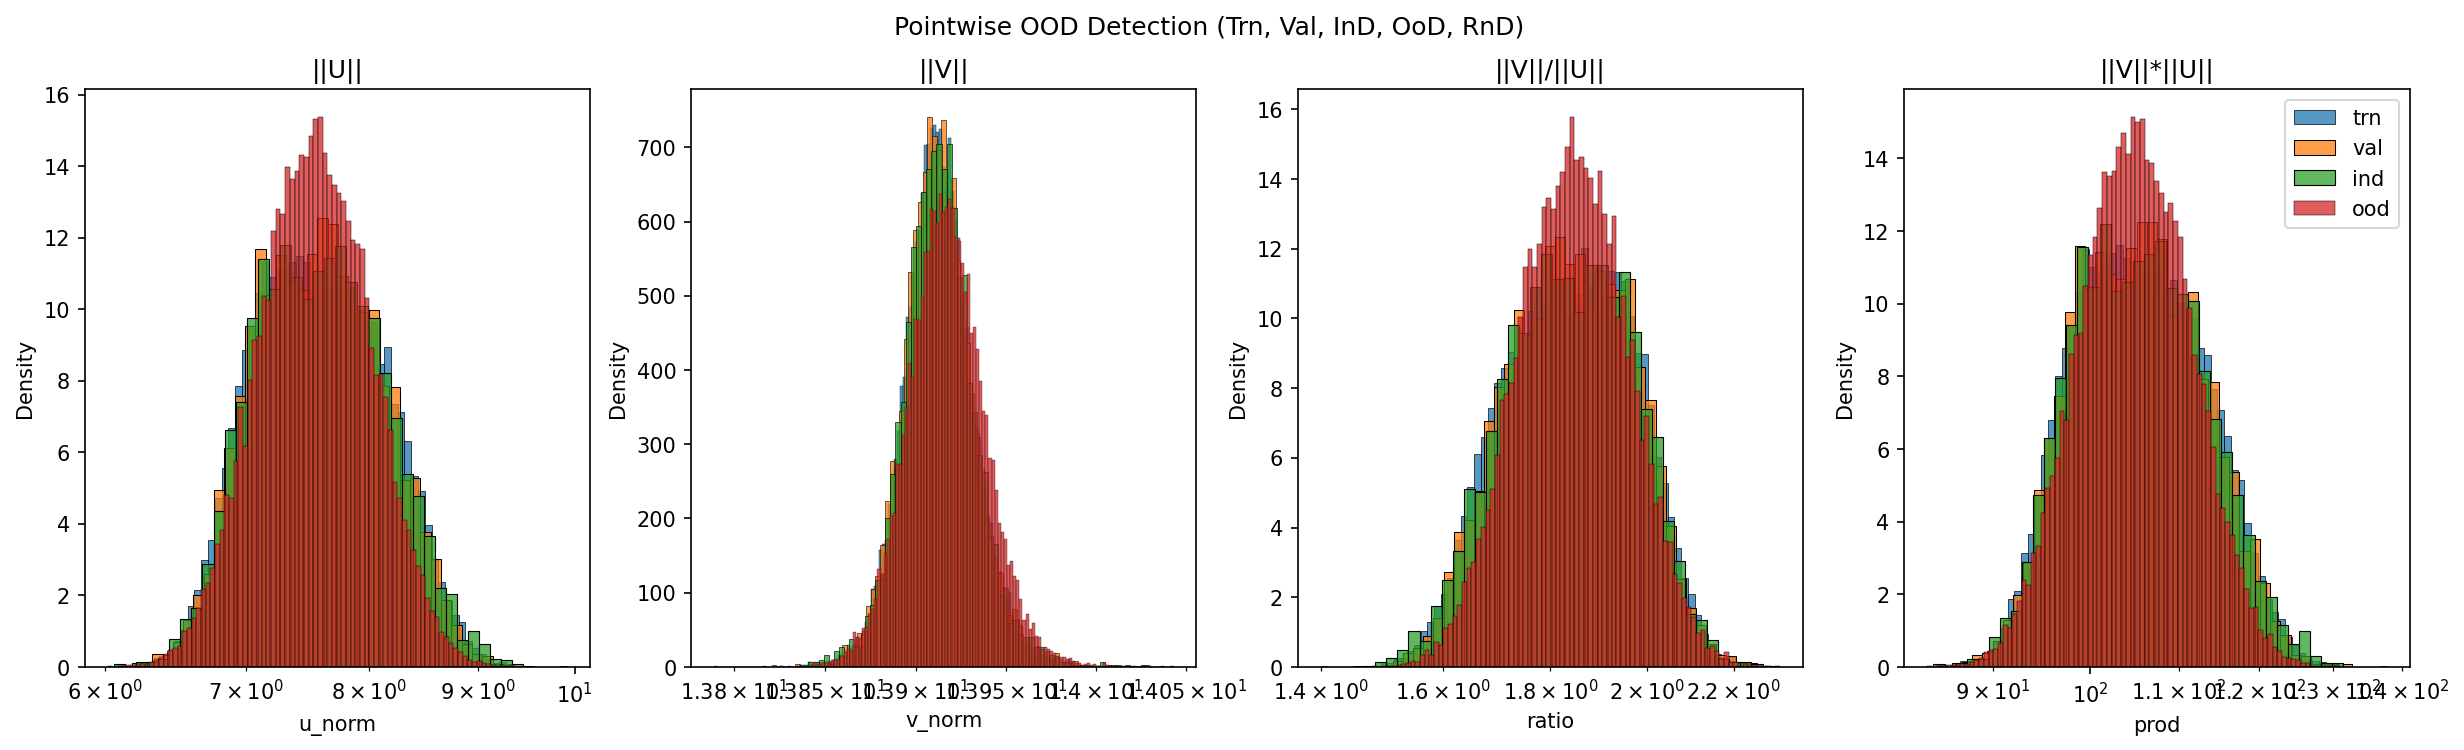

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_trn = pd.DataFrame(dict(u_norm=trn_u_norms, v_norm=trn_v_norms, ratio=trn_v_norms/trn_u_norms, prod=trn_v_norms*trn_u_norms, target=trn_targets))
data_val = pd.DataFrame(dict(u_norm=val_u_norms, v_norm=val_v_norms, ratio=val_v_norms/val_u_norms, prod=val_v_norms*val_u_norms, target=val_targets))
data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms, target=ind_targets))
if ood_str:
    data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms, target=ood_targets))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))
fig.suptitle("Pointwise OOD Detection (Trn, Val, InD, OoD, RnD)")

sns.histplot(data=data_trn, x="u_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax1)
sns.histplot(data=data_val, x="u_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax1)
sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax1)
if ood_str:
    sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax1)
# sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax1)

sns.histplot(data=data_trn, x="v_norm", log_scale=True, fill=True, label='trn', stat='density', ax=ax2)
sns.histplot(data=data_val, x="v_norm", log_scale=True, fill=True, label='val', stat='density', ax=ax2)
sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', stat='density', ax=ax2)
if ood_str:
    sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', stat='density', ax=ax2)
# sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', stat='density', ax=ax2)

sns.histplot(data=data_trn, x="ratio", log_scale=True, fill=True, label='trn', stat='density', ax=ax3)
sns.histplot(data=data_val, x="ratio", log_scale=True, fill=True, label='val', stat='density', ax=ax3)
sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', stat='density', ax=ax3)
if ood_str:
    sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', stat='density', ax=ax3)
# sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', stat='density', ax=ax3)

sns.histplot(data=data_trn, x="prod", log_scale=True, fill=True, label='trn', stat='density', ax=ax4)
sns.histplot(data=data_val, x="prod", log_scale=True, fill=True, label='val', stat='density', ax=ax4)
sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', stat='density', ax=ax4)
if ood_str:
    sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', stat='density', ax=ax4)
# sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', stat='density', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.show()

In [13]:
from scipy import stats
print("Trn", trn_v_norms.min(), trn_v_norms.max(), trn_v_norms.ptp())
print("Val", val_v_norms.min(), val_v_norms.max(), val_v_norms.ptp())
print("Ind", ind_v_norms.min(), ind_v_norms.max(), ind_v_norms.ptp())
if ood_str:
    print("Ood", ood_v_norms.min(), ood_v_norms.max(), ood_v_norms.ptp())
print("Rnd", rnd_v_norms.min(), rnd_v_norms.max(), rnd_v_norms.ptp())

if ood_str:
    ks_ind_ood = stats.kstest(ind_v_norms, ood_v_norms)
    print(ks_ind_ood)

Trn 13.825778 14.027262 0.20148373
Val 13.820705 14.029352 0.20864677
Ind 13.840811 14.027977 0.18716621
Ood 13.78906 14.043088 0.25402832
Rnd 26.023802 31.294464 5.2706623
KstestResult(statistic=0.09794883899844642, pvalue=8.984129409629912e-38, statistic_location=13.922581, statistic_sign=1)


[2 1 0 4 3 5 9 6 7 8]


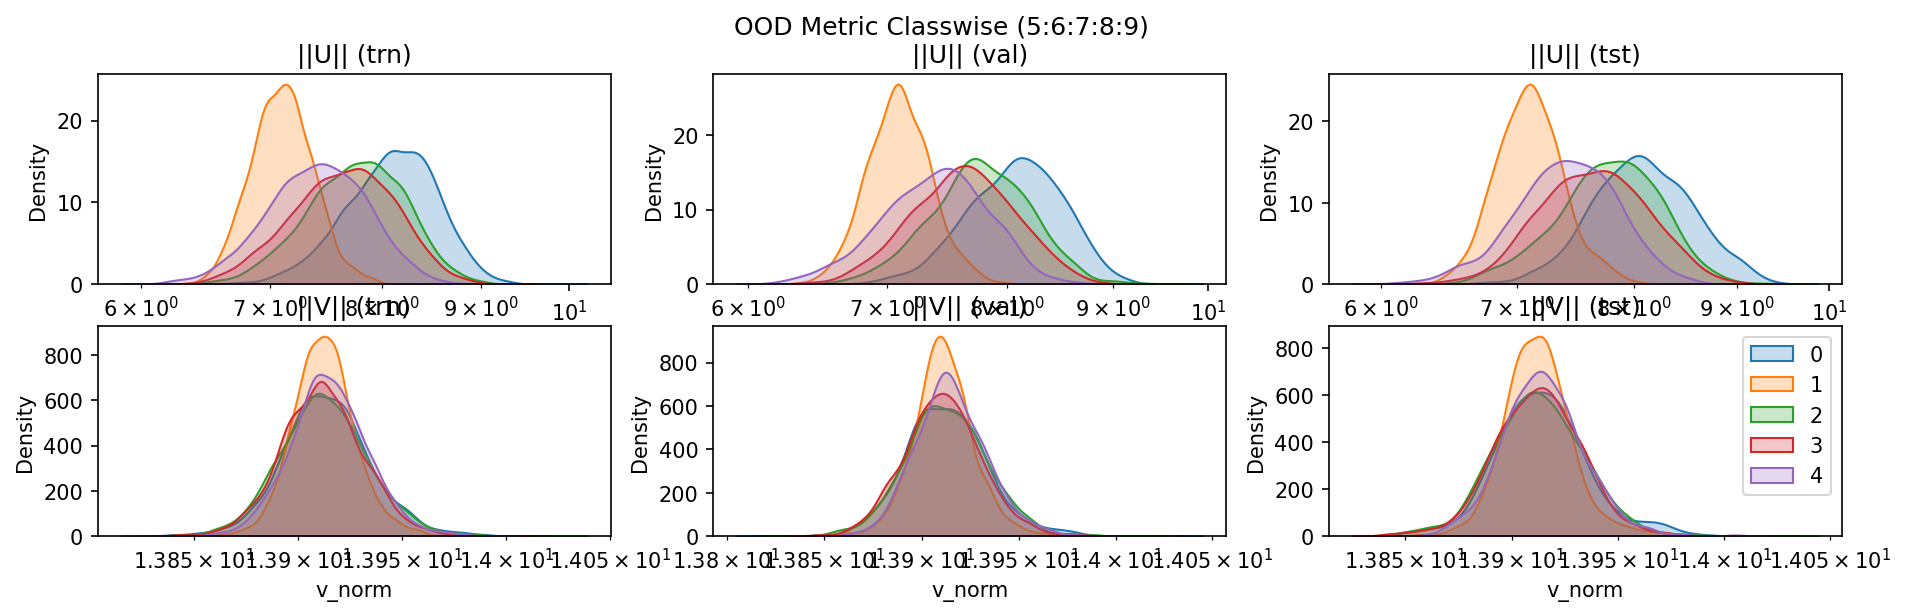

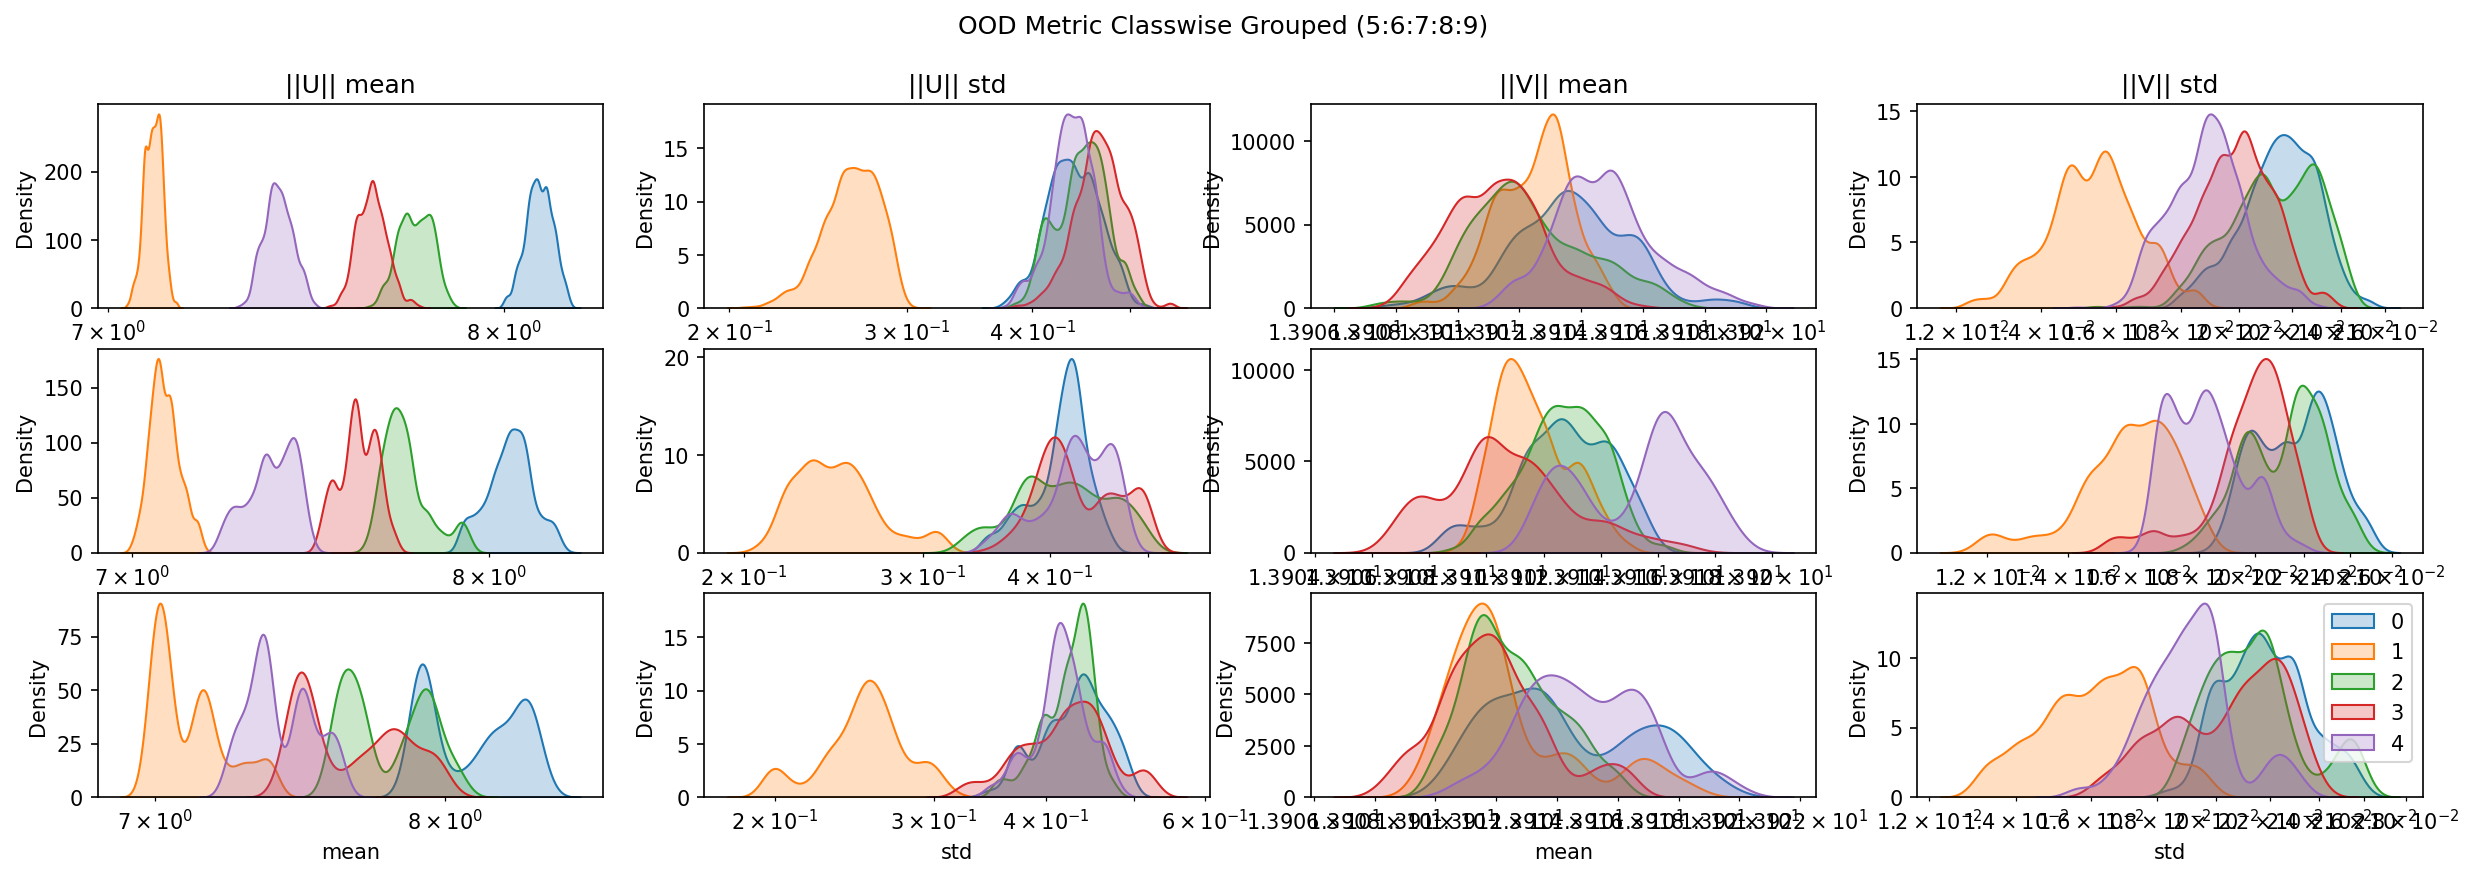

In [14]:
if ood_str:
    data_tst = pd.concat([data_ind, data_ood], axis=0)
else:
    data_tst = data_ind
print(data_tst['target'].unique())

N = 128

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(5):
    df_trn = data_trn[data_trn['target'] == i]
    df_val = data_val[data_val['target'] == i]
    df_tst = data_tst[data_tst['target'] == i]
    pointwise_trn[i] = df_trn.copy()
    pointwise_val[i] = df_val.copy()
    pointwise_tst[i] = df_tst.copy()
    groupwise_trn[i] = df_trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = df_val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = df_tst.rolling(N).agg(['mean', 'std']).dropna().copy()

# pointwise
fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, figsize = (15, 4))
fig.suptitle(f"OOD Metric Classwise ({ood_str})")

for i in range(5):
    df_trn = pointwise_trn[i]
    df_val = pointwise_val[i]
    df_tst = pointwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_val, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst, x="u_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_tst, x="v_norm", log_scale=True, fill=True, label=config.labels[i], ax=ax6)

ax1.title.set_text('||U|| (trn)')
ax2.title.set_text('||U|| (val)')
ax3.title.set_text('||U|| (tst)')
ax4.title.set_text('||V|| (trn)')
ax5.title.set_text('||V|| (val)')
ax6.title.set_text('||V|| (tst)')
plt.legend()
plt.show()
    
# groupwise
fig, ([ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8], [ax9, axA, axB, axC]) = plt.subplots(3, 4, figsize = (20, 6))
fig.suptitle(f"OOD Metric Classwise Grouped ({ood_str})")

for i in range(5):
    df_trn = groupwise_trn[i]
    df_val = groupwise_val[i]
    df_tst = groupwise_tst[i]
    if len(df_trn) > 0:
        sns.kdeplot(data=df_trn.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax1)
        sns.kdeplot(data=df_trn.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax2)
        sns.kdeplot(data=df_trn.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax3)
        sns.kdeplot(data=df_trn.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax4)
    if len(df_val) > 0:
        sns.kdeplot(data=df_val.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax5)
        sns.kdeplot(data=df_val.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax6)
        sns.kdeplot(data=df_val.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax7)
        sns.kdeplot(data=df_val.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=ax8)
    if len(df_tst) > 0:
        sns.kdeplot(data=df_tst.u_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=ax9)
        sns.kdeplot(data=df_tst.u_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axA)
        sns.kdeplot(data=df_tst.v_norm, x="mean", log_scale=True, fill=True, label=config.labels[i], ax=axB)
        sns.kdeplot(data=df_tst.v_norm, x="std", log_scale=True, fill=True, label=config.labels[i], ax=axC)

ax1.title.set_text('||U|| mean')
ax2.title.set_text('||U|| std')
ax3.title.set_text('||V|| mean')
ax4.title.set_text('||V|| std')
plt.legend()
plt.show()

In [15]:
# save vector norms for hypothesis testing

base_path = Path(f"assets/embeddings/{config.dataset_name}_{config.model_name}_M{config.emb_dims}_{ood_str}")
base_path.mkdir(exist_ok=True)

for i in range(5):
    df_trn = pointwise_trn.get(i, None)
    df_val = pointwise_val.get(i, None)
    df_tst = pointwise_tst.get(i, None)
    if df_trn is not None and len(df_trn) > 0:
        np.save(base_path / f"train_{i}.npy", df_trn.v_norm.values)
    if df_val is not None and len(df_val) > 0:
        np.save(base_path / f"val_{i}.npy", df_val.v_norm.values)
    if df_tst is not None and len(df_tst) > 0:
        np.save(base_path / f"test_{i}.npy", df_tst.v_norm.values)